In [ ]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder # categorical to number
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from yellowbrick.classifier.rocauc import roc_auc

!pip install scikit-optimize # needed to import skopt
from skopt import BayesSearchCV

from wordcloud import WordCloud
from matplotlib import pyplot as plt

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
with open('text', 'r') as fp:
  text = json.load(fp)
with open('labels', 'r') as fp:
  labels = json.load(fp)

In [ ]:
text[0]

"b'There is now ample evidence that dust is already present in abundance at high z. However, given the faintness of distant galaxies in the optical and the NIR, datasets are still limited and how the dust affects the emerging radiation of galaxies at very high redshift is not yet fully understood. Using the ALPINE survey, our objective is to quantify the dust attenuation properties in galaxies at z=4.4-5.5, and in particular the shape of their attenuation curve. Using the CIGALE code, we model the stellar populations and their interaction with the dust in order to measure some of the physical properties of a subsample of 23 main-sequence ALPINE galaxies. We find that the attenuation curves span a broad range of properties, from curves that are much steeper than the SMC extinction curve, to shallower than the starburst attenuation curve. The shape of the attenuation curves strongly depends on the V-band attenuation. Galaxies with the lowest attenuation also present the steepest curves. 

# Data partition
In this case we need to preprocess unstructured data into tabular data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(text,labels, test_size=0.3,random_state=42,stratify=labels) # makes split so that the values proportion is same to train&test



# non-tabular to tabular

In [ ]:
X_train[0]

"b'The Gauss-Bonnet curvature invariant has attracted the attention of physicists and mathematicians over the years. In particular, it has recently been proved that black holes can support external matter configurations that are non-minimally coupled to the Gauss-Bonnet invariant of the curved spacetime. Motivated by this physically interesting behavior of black holes in Einstein-Gauss-Bonnet theories, we present a detailed {\\\\it analytical} study of the physical and mathematical properties of the Gauss-Bonnet curvature invariant ${\\\\cal G}_{\\\\text{Kerr}}(r,\\\\cos\\\\theta;a/M)$ of spinning Kerr black holes in the spacetime region outside the horizon. Interestingly, we prove that, for all spinning Kerr spacetimes in the physically allowed regime $a/M\\\\in[0,1]$, the spin-dependent maximum curvature of the Gauss-Bonnet invariant is attained at the equator of the black-hole surface. Intriguingly, we reveal that the location of the global minimum of the Gauss-Bonnet invariant has 

Transf. to data matrix

  From sklearn
  * CountVectorizer - word count & binary rep.
  * TfidfVectorizer - TFIDF of words

       

In [ ]:
# label encoder-transf. labels values to numerical
label_encoder = LabelEncoder()
y_train_l = label_encoder.fit_transform(y_train)
y_test_l = label_encoder.transform(y_test)
cls = label_encoder.inverse_transform(np.unique(y_train_l))

In [ ]:
voc_size = 1000
# remove useless words of english & max. words of 1000 per text
# binary=true only returns if word is used; binary=false check if
cvec = CountVectorizer(stop_words='english', max_features=voc_size, binary=True)
X_train_v = cvec.fit_transform(X_train)
X_test_v = cvec.transform(X_test)

(-0.5, 399.5, 199.5, -0.5)

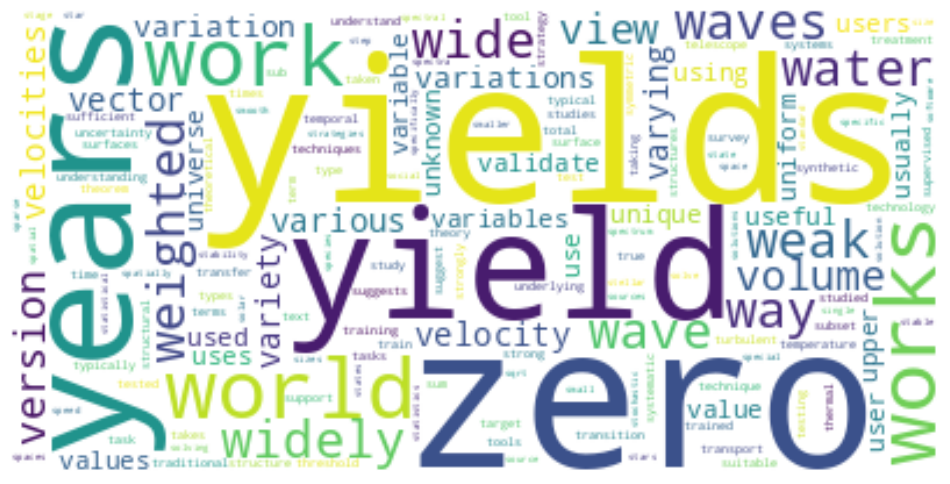

In [ ]:
wordcloud = WordCloud(background_color="white").generate_from_frequencies(cvec.vocabulary_)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


# Dimensionality reduction
  For exploratory analysis

In [ ]:
print(type(X_train_v))

<class 'scipy.sparse._csr.csr_matrix'>


<Axes: xlabel='0', ylabel='1'>

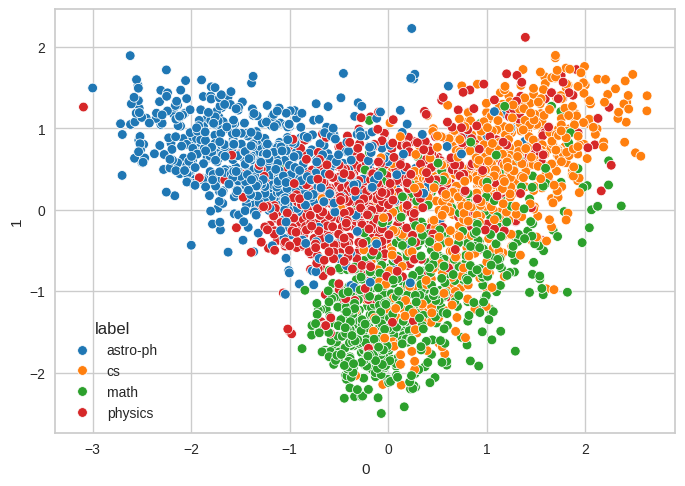

In [ ]:
pca = PCA()
tdata = pca.fit_transform(np.asarray(X_train_v.todense())) # form sparse to dense matrix
# axis=0 concatenate by index; axis=1 concatenate by columns
df_data = pd.concat([pd.DataFrame(tdata[:,:2]), pd.DataFrame({'label': y_train})],axis=1)

sns.scatterplot(x=0, y=1, hue='label', data=df_data, palette='tab10')


# Linear kernel

In [ ]:
param = {'C':10**np.linspace(-3,3,101)}

lsvc = SVC(kernel='linear', max_iter=25000, random_state=0) # cache_size of kernel (in MB)

lsvc_search = BayesSearchCV(lsvc, param, n_iter = 15, cv=5, n_jobs=-1, refit=True,random_state=0)

lsvc_search.fit(X_train_v, y_train_l)

BayesSearchCV(cv=5,
              estimator=SVC(kernel='linear', max_iter=25000, random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])})

In [ ]:
show_html(pd.DataFrame(lsvc_search.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,{'C': 0.012022644346174132},0.781786,1
3,{'C': 0.006918309709189363},0.781071,2
4,{'C': 0.023988329190194897},0.776071,3
8,{'C': 0.0034673685045253167},0.772500,4
1,{'C': 0.03630780547701014},0.765000,5


## Classif. report

In [ ]:
print(classification_report(lsvc_search.predict(X_test_v), y_test_l, target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.86      0.91      0.88       286
          cs       0.72      0.75      0.74       289
        math       0.78      0.73      0.76       322
     physics       0.73      0.72      0.72       303

    accuracy                           0.77      1200
   macro avg       0.77      0.78      0.77      1200
weighted avg       0.77      0.77      0.77      1200



## Confusion matrix

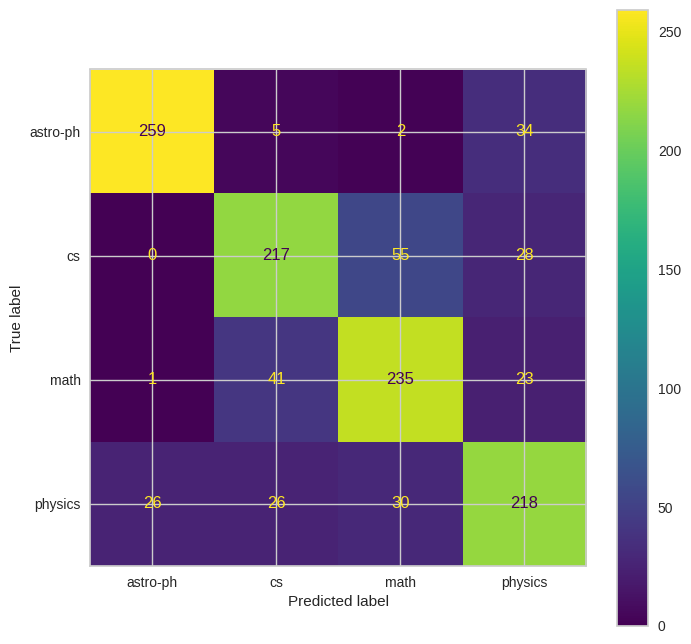

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lsvc_search,X_test_v, y_test_l, display_labels=cls, ax=plt.subplot())

## Roc curve

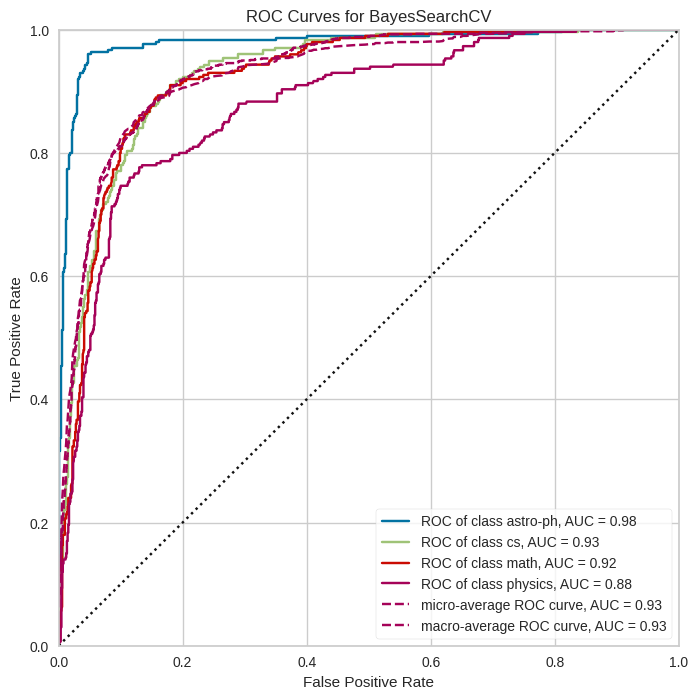

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(lsvc_search, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls);

# Polynomial kernel

In [ ]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3]}

psvc = SVC(kernel='poly', max_iter=25000, random_state=0) # cache_size of kernel (in MB)

psvc_search = BayesSearchCV(psvc, param, n_iter = 15, cv=5, n_jobs=-1, refit=True,random_state=0)

psvc_search.fit(X_train_v, y_train_l)

/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 3), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/space/space.py:116: UserWarning: Dimension [2, 3] was inferred to Integer(low=2, high=3, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categoric

BayesSearchCV(cv=5,
              estimator=SVC(kernel='poly', max_iter=25000, random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'degree': [2, 3]})

In [ ]:
show_html(pd.DataFrame(psvc_search.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'C': 1.513561248436207, 'degree': 2}",0.785714,1
12,"{'C': 1.9952623149688788, 'degree': 2}",0.785000,2
13,"{'C': 2.6302679918953813, 'degree': 2}",0.784643,3
14,"{'C': 0.8709635899560805, 'degree': 2}",0.783571,4
10,"{'C': 380.1893963205613, 'degree': 2}",0.781429,5


## Classif. report

In [ ]:
print(classification_report(psvc_search.predict(X_test_v), y_test_l, target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.86      0.91      0.88       281
          cs       0.73      0.76      0.74       289
        math       0.80      0.71      0.75       336
     physics       0.71      0.73      0.72       294

    accuracy                           0.77      1200
   macro avg       0.77      0.78      0.78      1200
weighted avg       0.77      0.77      0.77      1200



## Confusion matrix

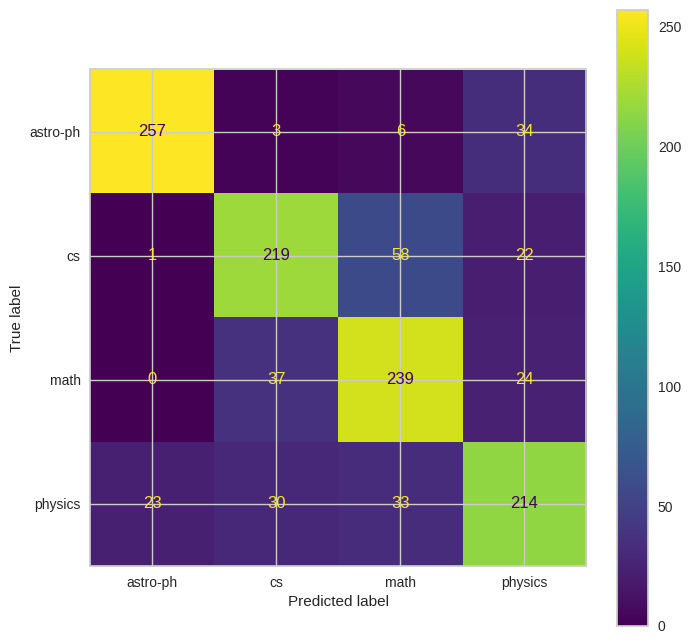

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(psvc_search,X_test_v, y_test_l, display_labels=cls, ax=plt.subplot())

## ROC curve

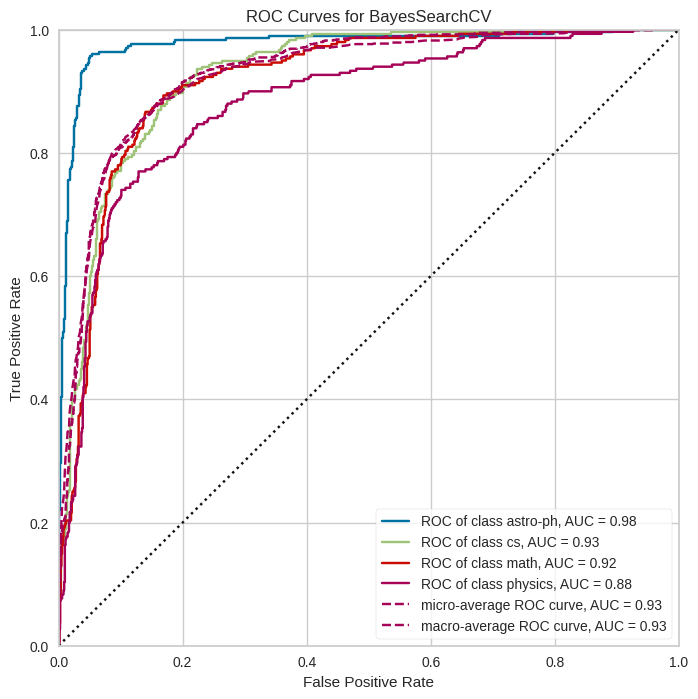

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(psvc_search, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls);

# RBF kernel

In [ ]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbf_svc = SVC(kernel='rbf', max_iter=25000, random_state=0) # cache_size of kernel (in MB)

rbf_svc_search = BayesSearchCV(rbf_svc, param, n_iter = 15, cv=5, n_jobs=-1, refit=True,random_state=0)

rbf_svc_search.fit(X_train_v, y_train_l)

BayesSearchCV(cv=5, estimator=SVC(max_iter=25000, random_state=0), n_iter=15,
              n_jobs=-1, random_state=0,
              search_spaces={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03,...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03]),
                             'gamma': ['scale', 'auto']})

In [ ]:
show_html(pd.DataFrame(rbf_svc_search.cv_results_).loc[:,['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
2,"{'C': 1.513561248436207, 'gamma': 'scale'}",0.791429,1
11,"{'C': 380.1893963205613, 'gamma': 'scale'}",0.789286,2
13,"{'C': 144.5439770745928, 'gamma': 'scale'}",0.789286,2
10,"{'C': 1.1481536214968828, 'gamma': 'scale'}",0.788929,4
0,"{'C': 1.513561248436207, 'gamma': 'auto'}",0.769286,5


## Classif. report

In [ ]:
print(classification_report(rbf_svc_search.predict(X_test_v), y_test_l, target_names=cls))

              precision    recall  f1-score   support

    astro-ph       0.88      0.91      0.90       289
          cs       0.76      0.76      0.76       300
        math       0.78      0.74      0.76       319
     physics       0.73      0.75      0.74       292

    accuracy                           0.79      1200
   macro avg       0.79      0.79      0.79      1200
weighted avg       0.79      0.79      0.79      1200



## Confusion matrix

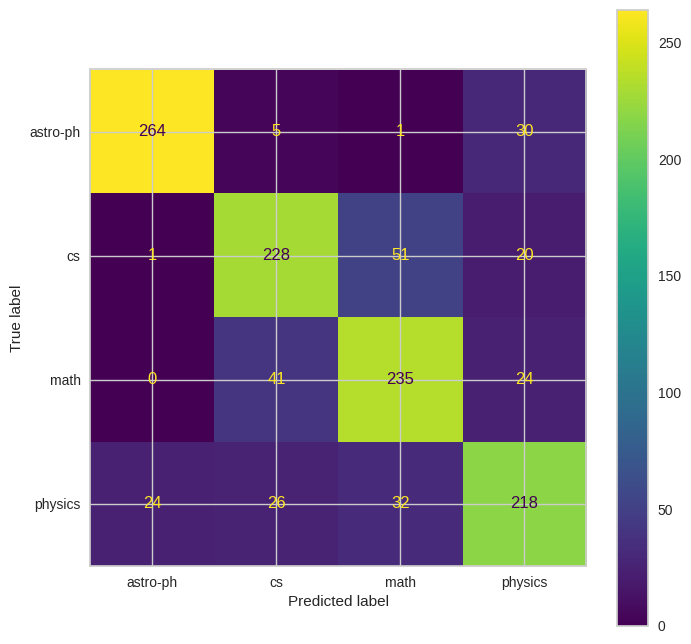

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(rbf_svc_search,X_test_v, y_test_l, display_labels=cls, ax=plt.subplot())

## ROC curve

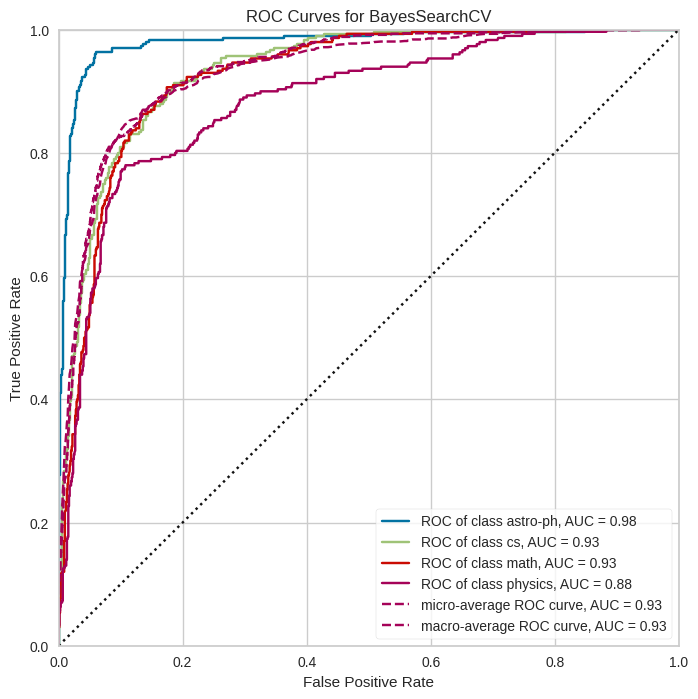

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(rbf_svc_search, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls);